In [1]:
cat = fits.open('../plane_gaiadr2_dust_06_12_19.fits')[1].data
cga = Table.read('../plane_gaia_apo13_match_07_03_19.txt', format='ascii')

### Match Apogee 13 and UVGAPS

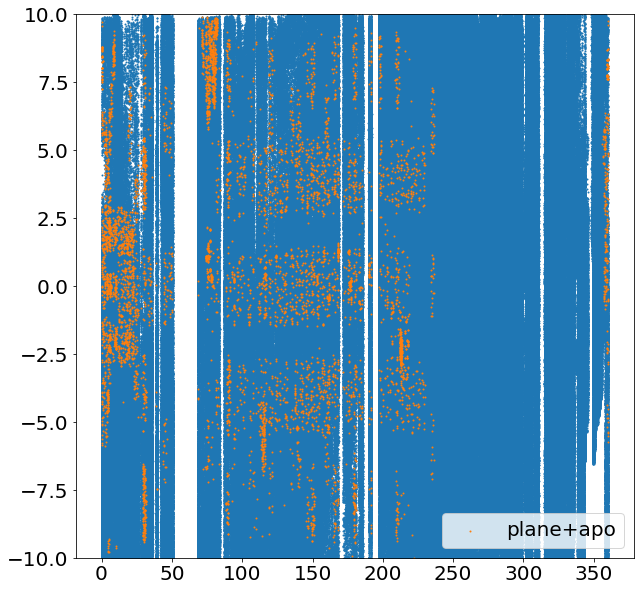

In [2]:
matplotlib.rcParams['figure.figsize'] = 10, 10
plt.scatter(cat['gl'], cat['gb'],s=1)
plt.scatter(cga['gl'], cga['gb'], s=1, label='plane+apo')
plt.legend(loc=4)
plt.ylim(-10, 10)
plt.show()

In [3]:
cuts = np.where(cga['FE_H'] > -10)
cga = cga[cuts]

### Cross match includes MS objects, cut out before looking at RC

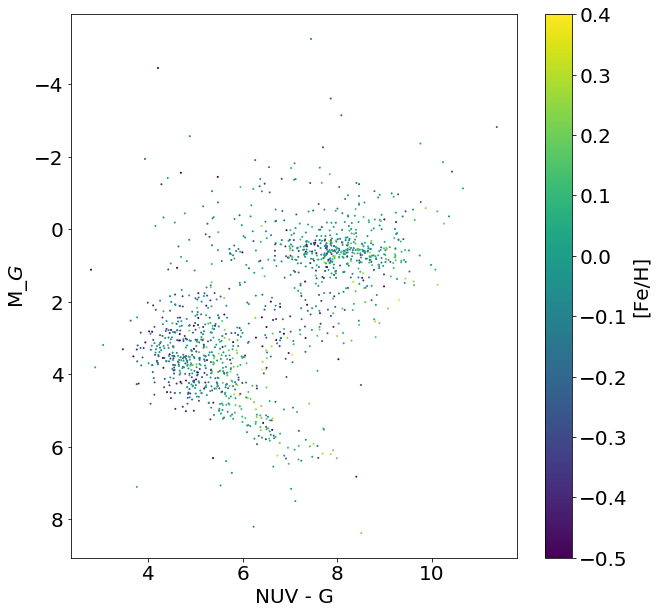

In [4]:
plt.scatter(cga['nuv']-cga['phot_g_mean_mag'], cga['phot_g_mean_mag']-cga['distmod'], c=cga['FE_H'], vmin=-0.5, vmax=.4, s=1)
plt.gca().invert_yaxis()
plt.xlabel('NUV - G')
plt.ylabel('M_$G$')
plt.colorbar().set_label('[Fe/H]')
plt.show()

In [5]:
rccut = np.where(((cga['nuv']-cga['phot_g_mean_mag']) > 7) & (cga['phot_g_mean_mag']-cga['distmod'] < 2))
rc = cga[rccut]
len(rc)

469

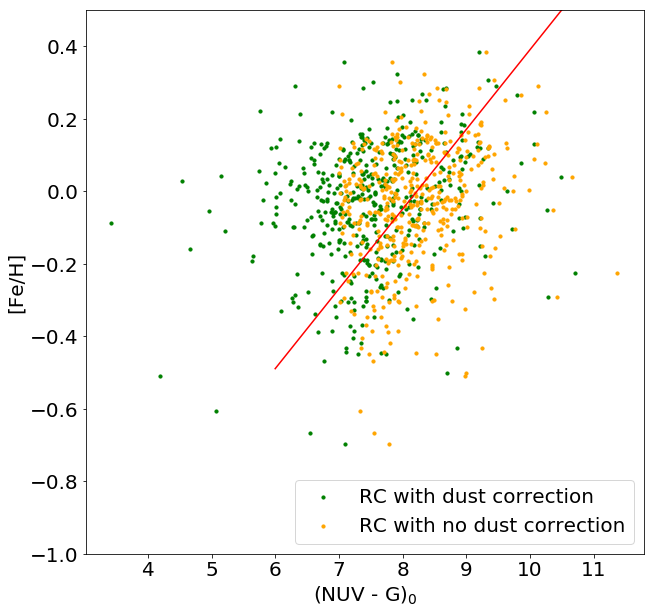

In [6]:
nuvgsamp = np.linspace(6, 10.5, 50)
fehsamp = 0.22*nuvgsamp - 1.81
#plt.scatter((cga['nuv']-cga['ebv']*7.24)-(cga['phot_g_mean_mag']-cga['ebv']*2.85), cga['FE_H'], s=1, label='All matches')
plt.scatter((rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85), rc['FE_H'], s=10, label='RC with dust correction', c='green')
plt.scatter((rc['nuv'])-(rc['phot_g_mean_mag']), rc['FE_H'], s=10, label='RC with no dust correction', c='orange')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.ylim(-1, 0.5)
plt.legend(loc=4)
plt.show()

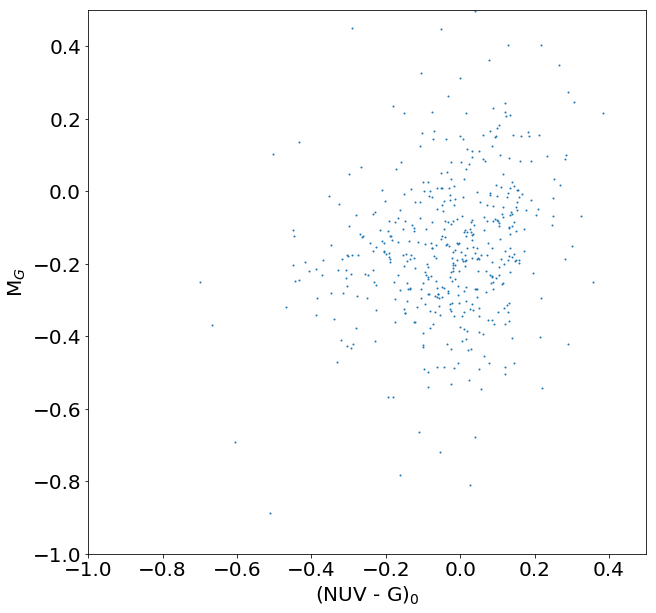

In [7]:
plt.scatter(rc['FE_H'], (0.22*((rc['nuv']-rc['ebv']*7.24)-(rc['phot_g_mean_mag']-rc['ebv']*2.85))-1.81), s=1)
plt.xlim(-1, 0.5)
plt.ylim(-1, 0.5)
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('M$_G$')
plt.show()

#### Load in Plane + Ting table, reduce to only RC pristine sample

In [8]:
ting = Table.read('../plane_gaia_ting.txt', format='ascii')
len(ting)
t2 = ting[np.where(ting['Classification'] == 'RC_Pristine')]

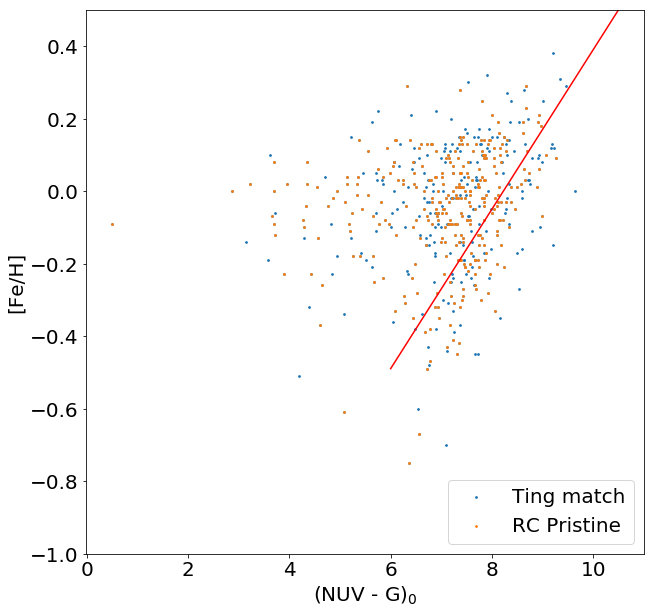

In [9]:
nuvgsamp = np.linspace(6, 10.5, 50)
fehsamp = 0.22*nuvgsamp - 1.81
plt.scatter((ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), ting['Fe_H'], s=3, label='Ting match')
plt.scatter((t2['nuv']-t2['ebv']*7.24)-(t2['phot_g_mean_mag_1']-t2['ebv']*2.85), t2['Fe_H'], s=3, label='RC Pristine')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.ylim(-1, 0.5)
plt.legend(loc=4)
plt.show()

#### These Ting RC stars are mostly all low alpha/Fe (thin disk) as expected 

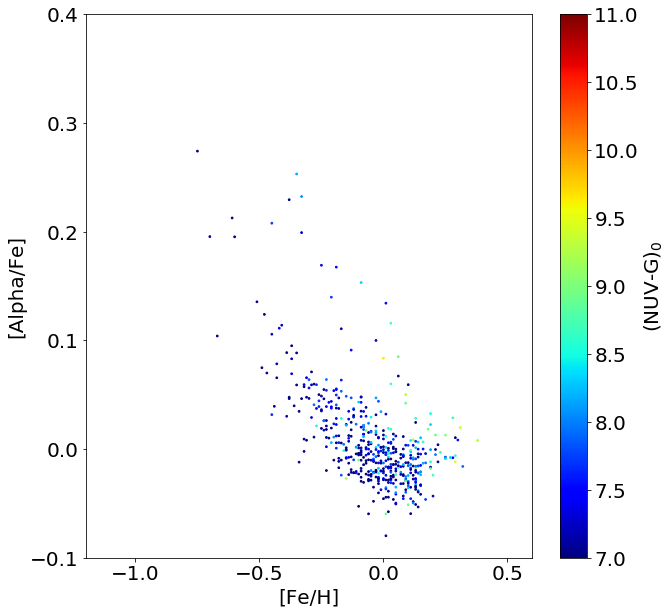

In [10]:
afe = ting['ALPHA_M'] + ting['M_H'] - ting['Fe_H']
ting['alphafe'] = afe
plt.scatter(ting['Fe_H'], afe, c=(ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), s=3, vmin=7, vmax=11, cmap=cm.jet)
plt.ylim(-.1, 0.4)
plt.xlim(-1.2, 0.6)
plt.xlabel('[Fe/H]')
plt.ylabel('[Alpha/Fe]')
plt.colorbar().set_label('(NUV-G)$_0$')
plt.show()

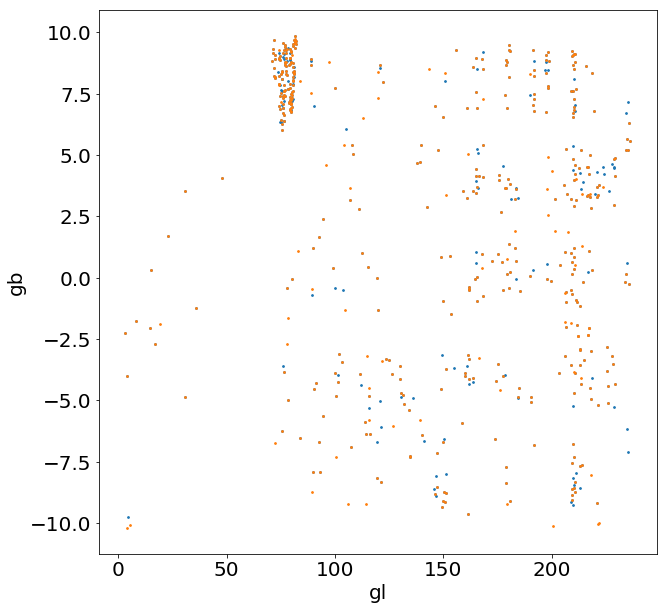

469
511


In [11]:
plt.scatter(ting['gl'], ting['gb'],s=3)
plt.scatter(rc['gl'], rc['gb'],s=3)
plt.xlabel('gl')
plt.ylabel('gb')
plt.show()
print(len(rc))
print(len(ting))

##### rc = plane + apogee in rc space, ting = plane + ting. Now load in rcais = GAIS + ting


In [12]:
rcais = fits.open('../asc_gaia_aporc_match_dust-05-03-18.fits')[1].data
q = np.where((rcais['ebv'] > 0) & (rcais['Fe_H_err'] > 0) & (rcais['phot_bp_mean_mag'] > 0) & (rcais['phot_rp_mean_mag'] > 0) & (rcais['Classification'] == 'RC_Pristine') & (rcais['dist'] < 3500) & (rcais['visibility_periods_used'] > 8) & (rcais['parallax_error']/rcais['parallax'] < 0.1))
rcais2 = rcais[q]

In [13]:
rcgal = SkyCoord(rc['ra_gaia']*u.deg, rc['dec_gaia']*u.deg, frame='icrs')
tinggal = SkyCoord(ting['ra_gaia']*u.deg, ting['dec_gaia']*u.deg, frame='icrs')
rcaisgal = SkyCoord(rcais['RA']*u.deg, rcais['DEC']*u.deg, frame='icrs')

rc1ind, rcais1ind, angseprc, ang3d = search_around_sky(rcgal, rcaisgal, 1*u.arcsec)
tind, rcais2ind, angsept, ang3d = search_around_sky(tinggal, rcaisgal, 1*u.arcsec)

pais = hstack([rc[rc1ind], Table(rcais[rcais1ind])])
tais = hstack([ting[tind], Table(rcais[rcais2ind])])
tais.sort('ra_gaia')
pais.sort('ra_gaia')

##### The two tables match the same 24 objects. Only 12 have the RC_Pristine classification

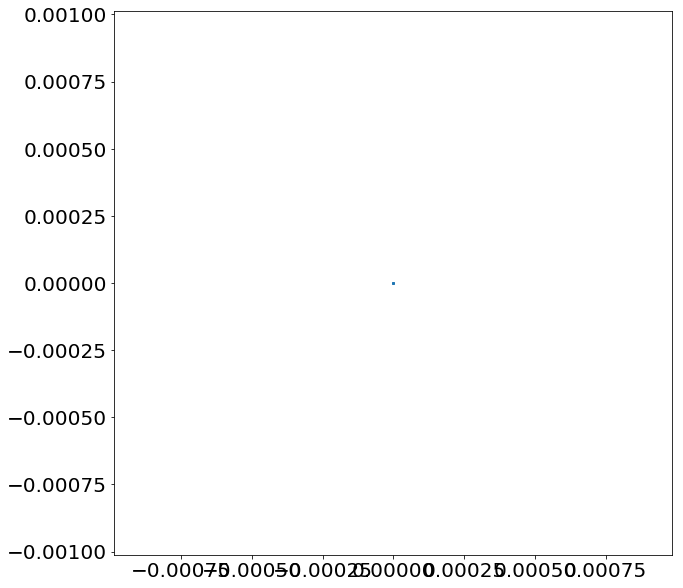

In [14]:
plt.scatter(pais['ra_gaia']-tais['ra_gaia'], pais['dec_gaia']-tais['dec_gaia'], s=1)
plt.show()

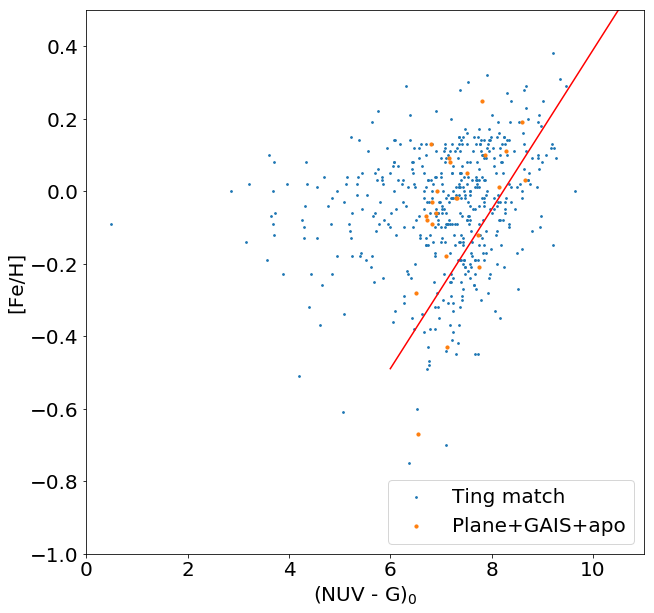

In [15]:
plt.scatter((ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), ting['Fe_H'], s=3, label='Ting match')
plt.scatter((pais['nuv']-pais['ebv_1']*7.24)-(pais['phot_g_mean_mag_1']-pais['ebv_1']*2.85), pais['Fe_H'], s=10, label='Plane+GAIS+apo')
plt.plot(nuvgsamp, fehsamp, c='red')
plt.xlabel('(NUV - G)$_0$')
plt.ylabel('[Fe/H]')
plt.ylim(-1, 0.5)
plt.legend(loc=4)
plt.show()


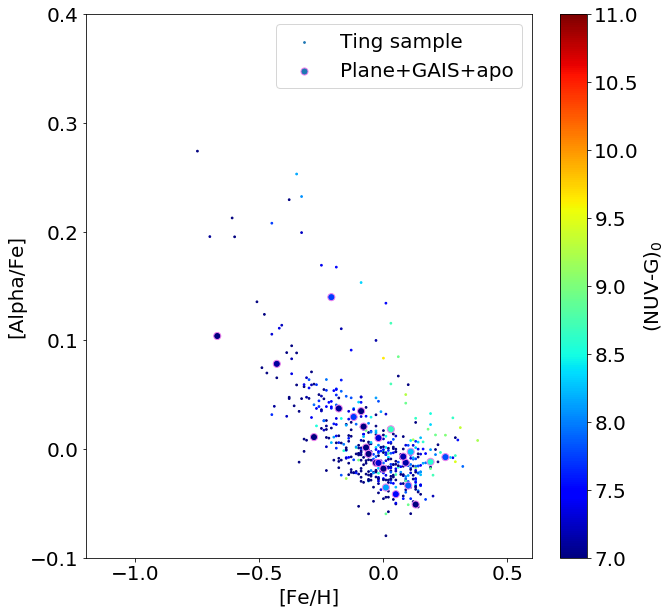

In [16]:
plt.scatter(ting['Fe_H'], ting['alphafe'], c=(ting['nuv']-ting['ebv']*7.24)-(ting['phot_g_mean_mag_1']-ting['ebv']*2.85), s=3, vmin=7, vmax=11, cmap=cm.jet, label='Ting sample')
plt.scatter(tais['Fe_H_1'], tais['alphafe'], c=(tais['nuv']-tais['ebv_1']*7.24)-(tais['phot_g_mean_mag_1']-tais['ebv_1']*2.85), s=50, vmin=7, vmax=11,edgecolor='violet', cmap=cm.jet, label='Plane+GAIS+apo')
plt.ylim(-.1, 0.4)
plt.xlim(-1.2, 0.6)
plt.xlabel('[Fe/H]')
plt.ylabel('[Alpha/Fe]')
plt.colorbar().set_label('(NUV-G)$_0$')
plt.legend(scatterpoints=1, loc=1)
plt.show()